In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import tensorflow_hub as hub
# Load model from TFHub into KerasLayer
model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
module = hub.KerasLayer(model_url,trainable=True)

In [3]:
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage.transform import resize
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [4]:
import tensorflow_datasets as tfds
import tensorflow as tf
dataset_name = 'cifar100'
ds_train_all, info_train = tfds.load(name=dataset_name, split=['train'], in_memory=False, with_info=True)
ds_test, info_test = tfds.load(name=dataset_name, split=['test'], in_memory=False, with_info=True)
ds_train_all = ds_train_all[0]
ds_test = ds_test[0]

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.0.incompleteF6QI1G/cifar100-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.0.incompleteF6QI1G/cifar100-test.tfrecord


Dataset cifar100 downloaded and prepared to /root/tensorflow_datasets/cifar100/3.0.0. Subsequent calls will reuse this data.


In [5]:
num_examples = info_train.splits['train'].num_examples
num_test = info_test.splits['test'].num_examples
NUM_CLASSES = 100

train_split = 0.8
num_train = int(train_split * num_examples)
ds_train = ds_train_all.take(num_train)
ds_val = ds_train_all.skip(num_train)
print(num_examples,num_train,num_test)

DATASET_NUM_TRAIN_EXAMPLES = num_examples

50000 40000 10000


In [6]:
print(ds_test)

<DatasetV1Adapter shapes: {coarse_label: (), image: (32, 32, 3), label: ()}, types: {coarse_label: tf.int64, image: tf.uint8, label: tf.int64}>


In [7]:
'''
Vẽ biểu đồ dataset
'''
def map_y(features):
  print(features)
  return features['label'].numpy()

print(ds_train)

# import matplotlib.pyplot as plt
# n, bins, patches = plt.hist(x=, bins='auto', color='#0504aa',
#                             alpha=0.7, rwidth=0.85)
# n, bins, patches = plt.hist(x=y_train[:], bins='auto', color='#607c8e',
#                             alpha=0.7, rwidth=0.85)
# plt.grid(axis='y', alpha=0.75)
# plt.xlabel('y')
# plt.ylabel('number')
# plt.title('Histogram dataset')
# maxfreq = n.max()
# # Set a clean upper y-axis limit.
# plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
# plt.show()

<DatasetV1Adapter shapes: {coarse_label: (), image: (32, 32, 3), label: ()}, types: {coarse_label: tf.int64, image: tf.uint8, label: tf.int64}>


In [8]:
# Preprocessing helper functions

# Create data pipelines for training and testing:
BATCH_SIZE = 256
SCHEDULE_LENGTH = 10000
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE
EPOCH = 25
STEPS_PER_EPOCH = 40000 // BATCH_SIZE
STEPS_VAL = 10000 // BATCH_SIZE
RESIZE_TO = 160
CROP_TO = 128


def cast_to_tuple(features):
  return (features['image'], features['label'])
  
def preprocess_train(features):
  features['image'] = tf.image.random_hue(features['image'], 0.08)
  features['image'] = tf.image.random_saturation(features['image'], 0.6, 1.6)
  features['image'] = tf.image.random_brightness(features['image'], 0.05)
  features['image'] = tf.image.random_contrast(features['image'], 0.7, 1.3)

  features['image'] = tf.image.random_flip_left_right(features['image'])
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.image.random_crop(features['image'], [CROP_TO, CROP_TO, 3])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

def preprocess_val(features):
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

pipeline_train = (ds_train
                  .shuffle(10000)
                  .repeat(int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH) + 1 + 50)  # repeat dataset_size / num_steps
                  .map(preprocess_train, num_parallel_calls=8)
                  .batch(BATCH_SIZE)
                  .map(cast_to_tuple)  # for keras model.fit
                  .prefetch(2))

pipeline_val = (ds_val.map(preprocess_val, num_parallel_calls=1)
                  .map(cast_to_tuple)  # for keras model.fit
                  .batch(BATCH_SIZE)
                  .prefetch(2))

In [9]:
# Add new head to the BiT model
class MyBiTModel(tf.keras.Model):
  """BiT with a new head."""

  def __init__(self, num_classes, module):
    super().__init__()

    self.num_classes = num_classes
    self.head = tf.keras.layers.Dense(num_classes, kernel_initializer='zeros')
    self.bit_model = module
  
  def call(self, images):
    bit_embedding = self.bit_model(images)
    # tf.keras.layers.BatchNormalization()
    return self.head(bit_embedding)

model = MyBiTModel(num_classes=NUM_CLASSES, module=module)

In [10]:
lr = 0.003 * BATCH_SIZE / 512 
SCHEDULE_BOUNDARIES = [500, 3000, 6000, 9000, 10000]

lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.01, lr*0.001, lr*0.0001, lr*0.00001])

# sgd
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# adam
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# es_patience = 10
# rlrop_patience = 5
# decay_rate = 0.5
# es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = es_patience, restore_best_weights = True, verbose = 1)
# # rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = rlrop_patience, 
# #                         factor = decay_rate, min_lr = 1e-6, verbose = 1)

In [11]:
model.compile(optimizer=optimizer,
             loss=loss_fn,
             metrics=['accuracy'])
 
# Fine-tune model
history = model.fit(
   pipeline_train,
   batch_size=BATCH_SIZE,
   steps_per_epoch=STEPS_PER_EPOCH,
   epochs=EPOCH,
   validation_data=pipeline_val,
   validation_steps=STEPS_VAL)
  #  callbacks = [es, rlrop])

Epoch 1/25
156/156 [==============================] - 159s 1s/step - loss: 1.1853 - accuracy: 0.6974 - val_loss: 0.5732 - val_accuracy: 0.8267
Epoch 2/25
156/156 [==============================] - 157s 1s/step - loss: 0.5772 - accuracy: 0.8237 - val_loss: 0.5133 - val_accuracy: 0.8428
Epoch 3/25
156/156 [==============================] - 158s 1s/step - loss: 0.4589 - accuracy: 0.8559 - val_loss: 0.4777 - val_accuracy: 0.8530
Epoch 4/25
156/156 [==============================] - 157s 1s/step - loss: 0.3430 - accuracy: 0.8900 - val_loss: 0.4107 - val_accuracy: 0.8737
Epoch 5/25
156/156 [==============================] - 157s 1s/step - loss: 0.2787 - accuracy: 0.9112 - val_loss: 0.4009 - val_accuracy: 0.8767
Epoch 6/25
156/156 [==============================] - 157s 1s/step - loss: 0.2619 - accuracy: 0.9178 - val_loss: 0.3969 - val_accuracy: 0.8773
Epoch 7/25
156/156 [==============================] - 158s 1s/step - loss: 0.2471 - accuracy: 0.9220 - val_loss: 0.3948 - val_accuracy: 0.8775

In [12]:
model.save_weights("best_weight.h5")

In [13]:
def preprocess_evaluate(features):
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

pipeline_evaluate = (ds_test.map(preprocess_evaluate, num_parallel_calls=1)
                  .map(cast_to_tuple)  # for keras model.fit
                  .batch(BATCH_SIZE)
                  .prefetch(2))
loss, acc = model.evaluate(pipeline_evaluate)
print('[accuracy_test]: {:5.2f}%'.format(100*acc))

40/40 [==============================] - 18s 462ms/step - loss: 0.4030 - accuracy: 0.8765
[accuracy_test]: 87.65%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


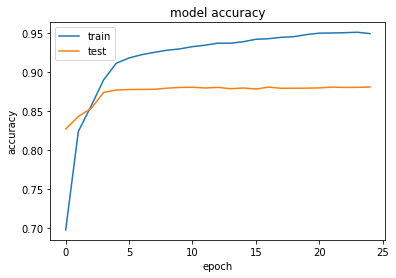

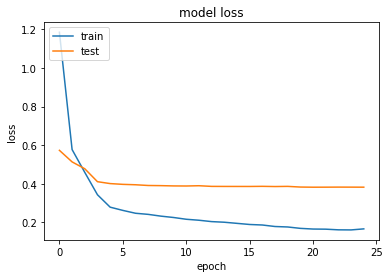

In [14]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()